In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from Utilities import orbits as orb
from Utilities import sections as sec
from scipy.integrate import odeint
import os
from Utilities.basic_units import radians

from Utilities.operators import make_tree, median_array, sort_list
from Utilities.time_extractor import days_since_distruption
matplotlib.rcParams['figure.dpi'] = 150

In [2]:
G = 1
m = 4
Mbh = 10**m
beta = 1
mstar = .5
Rstar = .47
n = 1.5
check = 'ComptonRes20' # 'Compton' or 'ComptonHiRes' or 'ComptonRes20'
folder = f'R{Rstar}M{mstar}BH{Mbh}beta{beta}S60n{n}'
snap = '169'
path = f'TDE/{folder}{check}/{snap}'
saving_path = f'Figs/{folder}/{check}'
print(f'We are in: {path}, \nWe save in: {saving_path}')
is_tde = True

Rt = Rstar * (Mbh/mstar)**(1/3)
Rp =  Rt / beta
R0 = 0.6 * Rp
apo = 2 * Rt * (Mbh/mstar)**(1/3)
threshold =  1/3

G_SI = 6.6743e-11
Msol = 2e30 #1.98847e30 # kg
Rsol = 7e8 #6.957e8 # m
t = np.sqrt(Rsol**3 / (Msol*G_SI ))

c = 3e8 / (7e8/t)
M_bh = 10**m
Rs = 2*G*Mbh / c**2

theta_width = 0.02

We are in: TDE/R0.47M0.5BH10000beta1S60n1.5ComptonRes20/169, 
We save in: Figs/R0.47M0.5BH10000beta1S60n1.5/ComptonRes20


In [3]:
# def find_streams(x_mid, y_mid, dim_mid, den_mid, theta_arr):
#     # first run to find the maxima (1 for every theta in theta_arr!). NB: the could be on different streams
#     cm, upper_tube, lower_tube, w = find_width_stream(x_mid, y_mid, dim_mid, den_mid, theta_arr) 
#     second_cm = []
#     for i in range(len(cm[0])): #cm has 3 rows and len(theta_arr) columns
#         #find again the normal plane
#         condition_coord = sec.transverse_plane(x_mid, y_mid, dim_mid, theta_arr[i])
#         x_norm = x_mid[condition_coord]
#         y_norm = y_mid[condition_coord]
#         r_norm = np.sqrt(x_norm**2 + y_norm**2)

#         den_norm = den_mid[condition_coord]
#         x_upper = upper_tube[0][i]
#         y_upper = upper_tube[1][i]
#         r_upper = np.sqrt(x_upper**2 + y_upper**2)
#         x_lower = lower_tube[0][i]
#         y_lower = lower_tube[1][i]
#         r_lower = np.sqrt(x_lower**2 + y_lower**2)

#         cond_rlow = np.logical_and(r_norm > R0, r_norm < r_lower)
#         x_second = x_norm[np.logical_or(cond_rlow, r_norm > r_upper)]
#         y_second = y_norm[np.logical_or(cond_rlow, r_norm > r_upper)]
#         den_second = den_norm[np.logical_or(cond_rlow, r_norm > r_upper)]
#         idx_cm2 = np.argmax(den_second)
#         if den_second[idx_cm2] > cm[2][i]/3:
#             second_cm.append([x_second[idx_cm2], y_second[idx_cm2], den_second[idx_cm2]])
#     # broadcast as cm
#     second_cm = np.transpose(second_cm)
#     return cm, second_cm

def parameters_orbit(p, a):
    En = G * Mbh * (p**2 * (a-Rs) - a**2 * (p-Rs)) / ((a**2-p**2) * (p-Rs) * (a-Rs))
    L = np.sqrt(2 * a**2 * (En + G*Mbh/(a-Rs)))
    return En, L

def solvr(x, theta):
    _, L = parameters_orbit(Rp, apo)
    u,y = x
    res =  np.array([y, (-u + G * Mbh / ((1 - Rs*u) * L)**2)])
    return res

def Witta_orbit(theta_data):
    u,y = odeint(solvr, [0, 0], theta_data).T 
    r = 1/u
    return r

Load data

In [4]:
data = make_tree(path, snap, is_tde, energy = False)

R = np.sqrt(data.X**2 + data.Y**2 + data.Z**2)
THETA, RADIUS_cyl = orb.to_cylindric(data.X, data.Y)
V = np.sqrt(data.VX**2 + data.VY**2 + data.VZ**2)
dim_cell = data.Vol**(1/3) # according to Elad
tfb = days_since_distruption(f'{path}/snap_{snap}.h5', m, mstar, Rstar, choose = 'tfb')

days after disruption: 1.347563076735333 // t_fall: 2.5777261297507925 // sim_time: 73.09576634427778


In [5]:
# # check if anglese are correct
# angle_check = -np.pi/4
# plt.figure(figsize=(2,2))
# plt.plot(X[np.abs(theta - angle_check) < 0.01], Y[np.abs(theta - angle_check) < 0.01], 'o', markersize = 0.5, c='k')
# plt.xlim(-1000,1000)
# plt.ylim(-1000,1000)
# plt.title(r'$\theta$ = '+ f'{np.round(angle_check,2)}')

In [6]:
# Cross section at midplane
midplane = np.abs(data.Z) < dim_cell
X_midplane, Y_midplane, Z_midplane, dim_midplane, VX_midplane, VY_midplane, VZ_midplane, Mass_midplane, Den_midplane, Press_midplane, Temp_midplane = \
    sec.make_slices([data.X, data.Y, data.Z, dim_cell, data.VX, data.VY, data.VZ, data.Mass, data.Den, data.Press, data.Temp], midplane)

In [7]:
theta_lim = 3/4 * np.pi
step = 0.1
theta_params = [-theta_lim, theta_lim, step]

# cfr tidal disruption 
xRt = np.linspace(-Rt, Rt, 100)
yRt = np.linspace(-Rt, Rt, 100)
xcfr, ycfr = np.meshgrid(xRt,yRt)
cfr = xcfr**2 + ycfr**2 - Rt**2

# cfr smoothing lenght
xR0 = np.linspace(-R0, R0, 100)
yR0 = np.linspace(-R0, R0, 100)
xcfr0, ycfr0 = np.meshgrid(xR0,yR0)
cfr0 = xcfr0**2 + ycfr0**2 - R0**2

# Parabolic orbit
ecc = 1
theta_arr_kep = np.arange(0, 2*np.pi, 0.01)
r_orbit = orb.keplerian_orbit(theta_arr_kep, apo, a = Rp, ecc = ecc)
x_K_orbit, y_K_orbit = orb.from_cylindric(theta_arr_kep, r_orbit) 

# Witta
theta_arr_kep = np.arange(-np.pi, np.pi, 0.01)
Witta_r = Witta_orbit(theta_arr_kep)
x_Witta_orbit, y_Witta_orbit = orb.from_cylindric(theta_arr_kep, Witta_r) 

# Density maxima orbit
theta_cm, r_cm = orb.find_maximum(X_midplane, Y_midplane, dim_midplane, Den_midplane, theta_params)
x_cm, y_cm = orb.from_cylindric(theta_cm, r_cm)

/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_74214/3102501304.py:44: RuntimeWarning: divide by zero encountered in divide
  r = 1/u


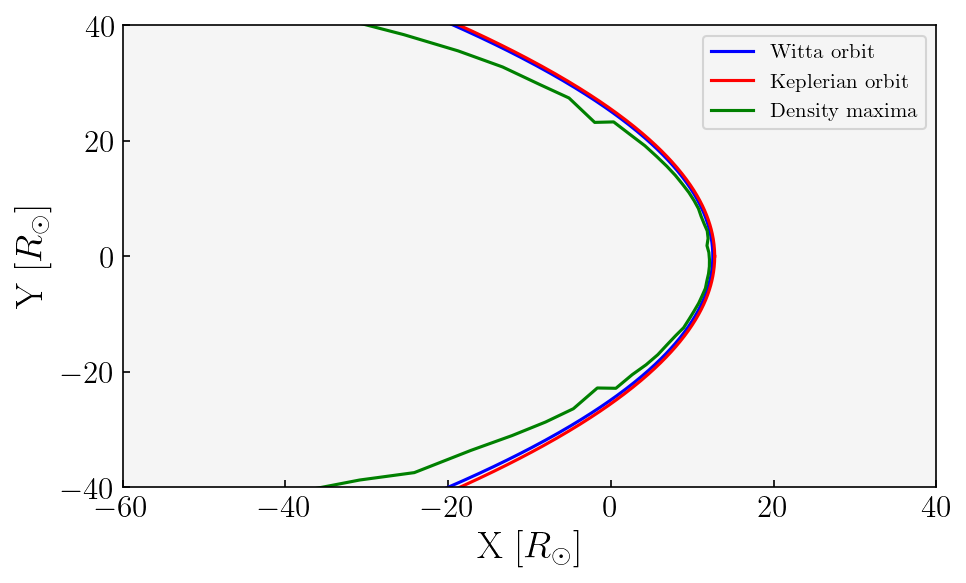

In [8]:
plt.figure(figsize=(7,4))
#plt.scatter(X_midplane, Y_midplane, c = np.log10(Den_midplane), cmap = 'viridis', s=1, vmin =-8, vmax = -7)
plt.plot(x_Witta_orbit, y_Witta_orbit, c='b',  label='Witta orbit')
plt.plot(x_K_orbit, y_K_orbit, c='r',  label='Keplerian orbit')
plt.plot(x_cm, y_cm, c='g', label='Density maxima')
plt.xlim(-60,40)
plt.ylim(-40, 40)
plt.xlabel(r'X [$R_\odot$]', fontsize = 18)
plt.ylabel(r'Y [$R_\odot$]', fontsize = 18)
plt.legend()

In [9]:
theta_arr, cm, upper_tube, lower_tube, width  = orb.find_width_stream(X_midplane, Y_midplane, dim_midplane, Den_midplane, theta_params)

In [10]:
print('Put this as upper limit: ', np.max(Den_midplane[np.abs(X_midplane-Rp) < 0.1]))

Put this as upper limit:  5.442178883889149e-07


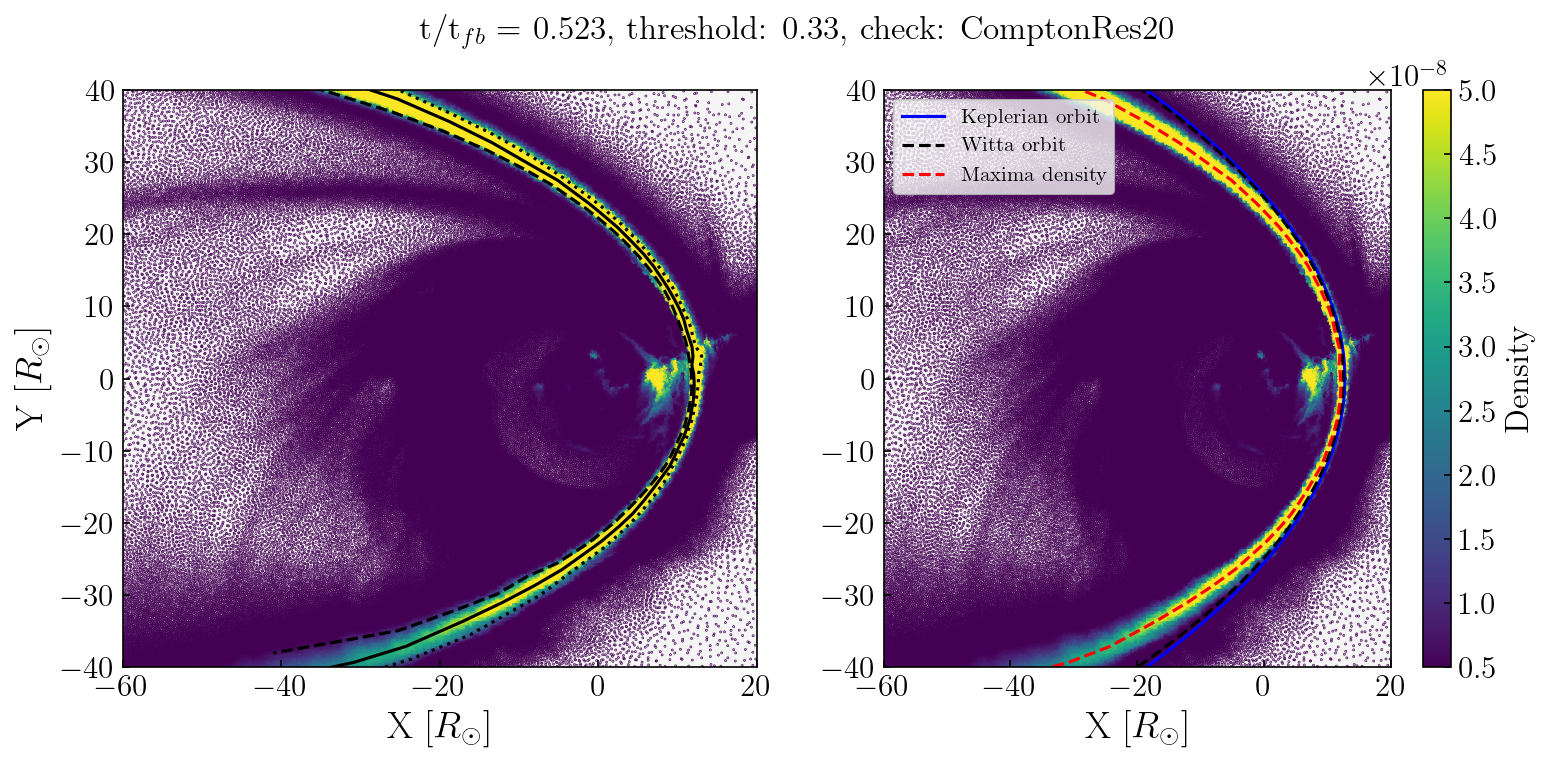

In [11]:
vdenmax = 5e-8
vdenmin = 5e-9#threshold * vdenmax
fig, ax = plt.subplots(1,2, figsize = (12,5))
img = ax[0].scatter(X_midplane, Y_midplane, c = Den_midplane, s = 0.1, cmap = 'viridis', vmin = vdenmin, vmax = vdenmax)
ax[0].plot(cm[0], cm[1], c = 'k')
ax[0].plot(upper_tube[0], upper_tube[1], linestyle = 'dotted', c = 'k')
ax[0].plot(lower_tube[0], lower_tube[1],  '--', c = 'k')
ax[0].set_xlim(-60,20)
ax[0].set_ylim(-40,40)
ax[0].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax[0].set_ylabel(r'Y [$R_\odot$]', fontsize = 18)

img1 = ax[1].scatter(X_midplane, Y_midplane, c = Den_midplane, s = 0.1, cmap = 'viridis', vmin = vdenmin, vmax = vdenmax)
cbar1 = plt.colorbar(img1)
cbar1.set_label(r'Density', fontsize = 16)
ax[1].plot(x_K_orbit, y_K_orbit, c = 'b', label = 'Keplerian orbit')
ax[1].plot(x_Witta_orbit, y_Witta_orbit, c = 'k', linestyle = '--', label = 'Witta orbit')
ax[1].plot(cm[0], cm[1], c = 'r', linestyle = '--', label = 'Maxima density')
ax[1].set_xlim(-60,20)
ax[1].set_ylim(-40, 40)
ax[1].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax[1].legend(loc = 'upper left')

plt.suptitle(r't/t$_{fb}$ = ' + str(np.round(tfb,3)) + f', threshold: {np.round(threshold, 2)}, check: {check}', fontsize = 16)

plt.savefig(f'{saving_path}/width&orb{snap}.png')


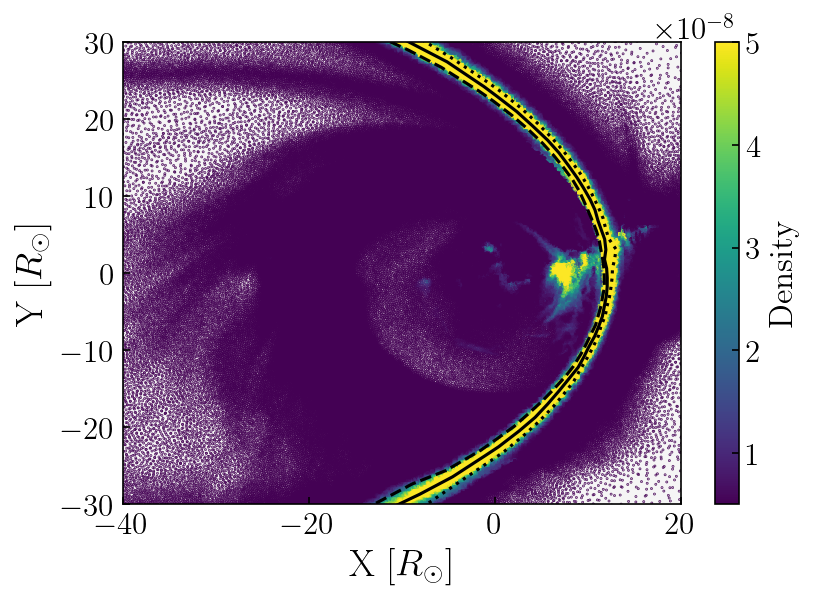

In [12]:
plt.figure(figsize = (6,4))
img = plt.scatter(X_midplane, Y_midplane, c = Den_midplane, s = 0.1, cmap = 'viridis', vmin = vdenmin, vmax = vdenmax)
cbar = plt.colorbar(img)
cbar.set_label(r'Density', fontsize = 16)
plt.plot(cm[0], cm[1], c = 'k')
plt.plot(upper_tube[0], upper_tube[1], linestyle = 'dotted', c = 'k')
plt.plot(lower_tube[0], lower_tube[1],  '--', c = 'k')
plt.xlim(-40,20)
plt.ylim(-30,30)
plt.xlabel(r'X [$R_\odot$]', fontsize = 18)
plt.ylabel(r'Y [$R_\odot$]', fontsize = 18)

plt.savefig(f'{saving_path}/zoomwidth&orb{snap}.png')

In [13]:
cm_r = np.sqrt(cm[0]**2 + cm[1]**2)
width_over_r = width / cm_r

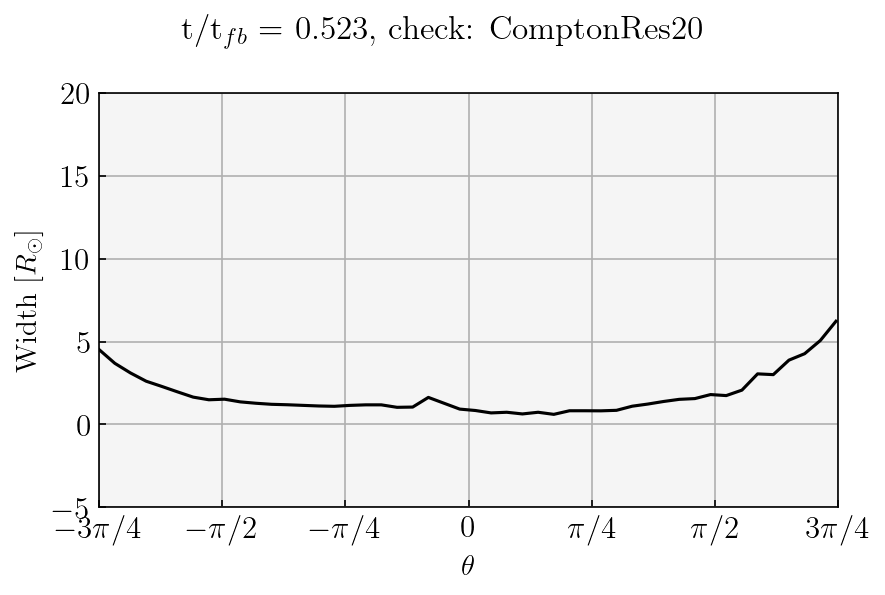

In [14]:
plt.figure(figsize=(6,4))
plt.plot(theta_arr * radians, width, c = 'k')
plt.xlabel(r'$\theta$', fontsize = 14)
plt.ylabel(r'Width [$R_\odot$]', fontsize = 14)
plt.xlim(-3/4*np.pi, 3/4*np.pi)
plt.ylim(-5,20)
plt.grid()

plt.suptitle(r't/t$_{fb}$ = ' + str(np.round(tfb,3)) + f', check: {check}', fontsize = 16)
plt.tight_layout()
plt.savefig(f'{saving_path}/width_theta{snap}.png')


In [15]:
try:
    file = open(f'data/{folder}/{np.round(tfb,1)}.txt', 'r')
    # Perform operations on the file
    file.close()
except FileNotFoundError:
    with open(f'data/{folder}/{np.round(tfb,1)}.txt','a') as fstart:
        # if file exist
        fstart.write(f'\n# theta \n')
        fstart.write((' '.join(map(str, theta_arr)) + '\n'))

with open(f'data/{folder}/width_time{np.round(tfb,1)}.txt','a') as file:
    file.write(f'# {check}, snap {snap} \n')
    file.write((' '.join(map(str, width)) + '\n'))

In [107]:
def width_dependence(r, normal = Rp):
    width_r = r**(1/2)
    return width_r

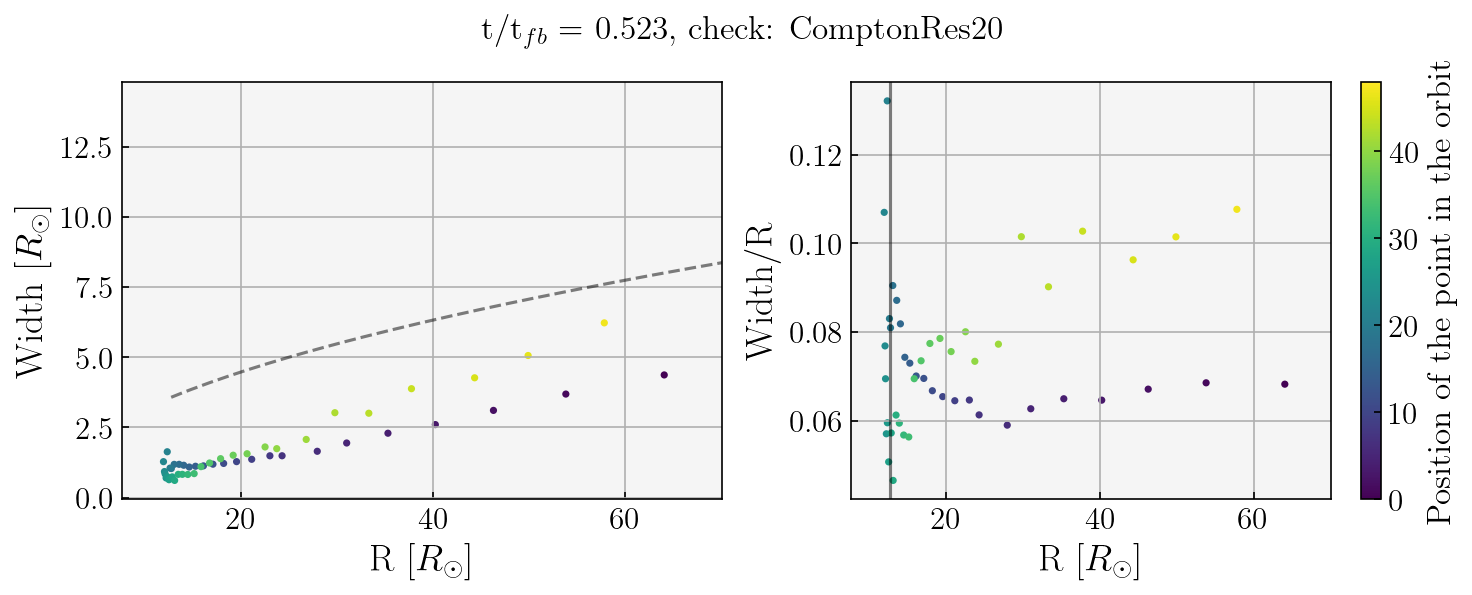

In [108]:
# if you want them sorted (according to angle) to use color and understand the order
theta_arr_list = list(theta_arr)
cm_r_sorted = sort_list(cm_r, theta_arr_list)
width_over_r_sorted = sort_list(width_over_r, theta_arr_list)
r_array = np.arange(Rp,200)

fig, ax = plt.subplots(1,2, figsize=(10,4))
img = ax[0].scatter(cm_r_sorted, width, c = np.arange(len(cm_r_sorted)), s = 6, vmin = 0, vmax = len(cm_r_sorted))
# cbar = plt.colorbar(img)
# cbar.set_label('Position of the point in the orbit', fontsize = 16)
ax[0].plot(r_array, width_dependence(r_array), c = 'k', linestyle = '--', alpha = 0.5, label = r'$R^{1/3}$')
ax[0].set_xlabel(r'R [$R_\odot$]', fontsize = 18)
ax[0].set_ylabel(r'Width [$R_\odot$]', fontsize = 18)
ax[0].set_xlim(R0,70)
ax[0].grid()

ax[1].axvline(Rp, c = 'k', alpha = 0.5)
img1 = ax[1].scatter(cm_r_sorted, width_over_r_sorted, c = np.arange(len(cm_r_sorted)), s = 6, vmin = 0, vmax = len(cm_r_sorted))
cbar1 = plt.colorbar(img1)
cbar1.set_label('Position of the point in the orbit', fontsize = 16)
#ax[1].plot(r_array, width_dependence(r_array), c = 'k', linestyle = '--', alpha = 0.5, label = r'$R^{3/2}$')
ax[1].set_xlabel(r'R [$R_\odot$]', fontsize = 18)
ax[1].set_ylabel(r'Width/R ', fontsize = 18)
ax[1].set_xlim(R0,70)
ax[1].grid()

plt.suptitle(r't/t$_{fb}$ = ' + str(np.round(tfb,3)) + f', check: {check}', fontsize = 16)
plt.tight_layout()
plt.savefig(f'{saving_path}/width_R{snap}.png')

Compare width

In [17]:
datawidth5 = np.loadtxt(f'data/{folder}/0.5.txt')
widthC5 = datawidth5[1]
widthHiRes5 = datawidth5[2]

In [18]:
datawidth7 = np.loadtxt(f'data/{folder}/0.7.txt')

theta_width7 = datawidth7[0]
widthC7 = datawidth7[1]
widthHiRes7 = datawidth7[2]
#widthRes207 = datawidth7[3]

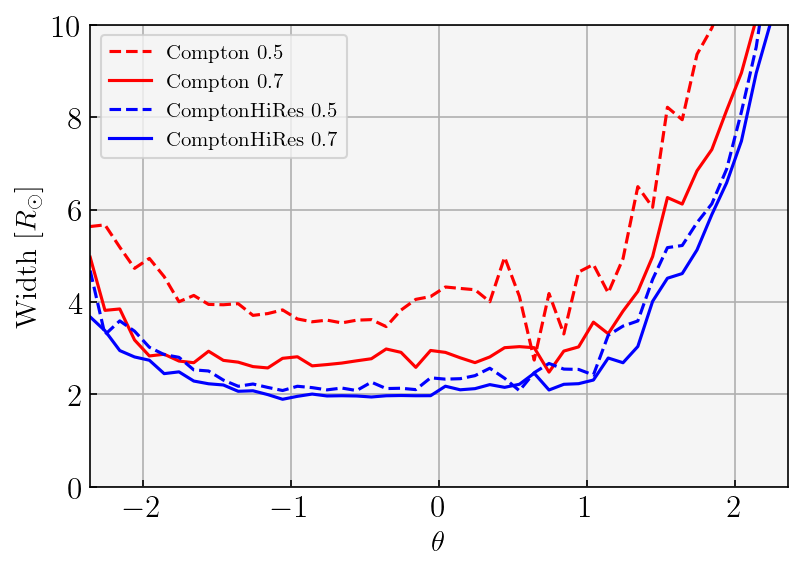

In [44]:
plt.figure(figsize=(6,4))
plt.plot(theta_width7, widthC5, '--', c = 'r', label = 'Compton 0.5')
plt.plot(theta_width7, widthC7, c = 'r', label = 'Compton 0.7')
plt.plot(theta_width7, widthHiRes5, '--', c = 'b', label = 'ComptonHiRes 0.5')
plt.plot(theta_width7, widthHiRes7, c = 'b', label = 'ComptonHiRes 0.7')
#plt.plot(theta_width7, widthRes207, c = 'g',  label = 'ComptonRes20')
plt.legend()
plt.xlabel(r'$\theta$', fontsize = 14)
plt.ylabel(r'Width [$R_\odot$]', fontsize = 14)
plt.xlim(-3/4*np.pi, 3/4*np.pi)
plt.ylim(0,10)
plt.grid()

plt.savefig(f'Figs/{folder}/width_comparison.png')

In [33]:
ratio5 = 1 - widthHiRes5/widthC5
ratio7 = 1- widthHiRes7/widthC7

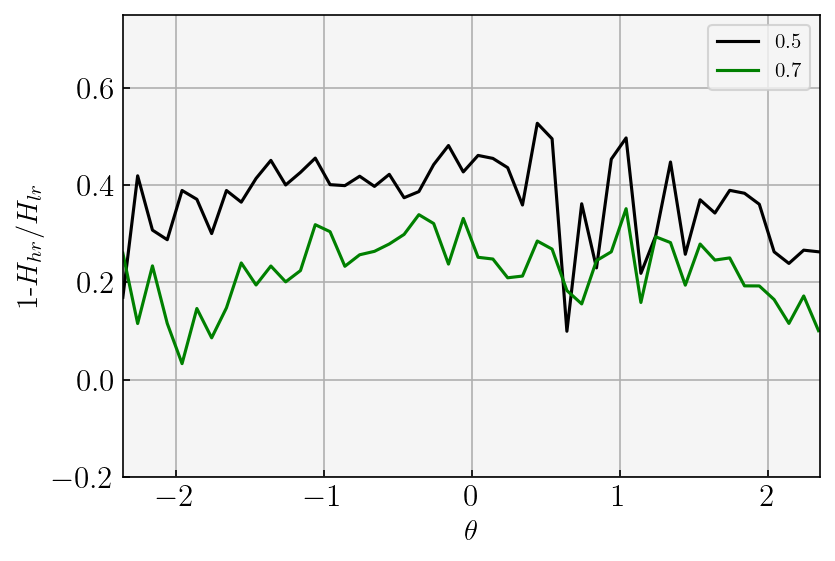

In [43]:
plt.figure(figsize=(6,4))
plt.plot(theta_width7, ratio5, c = 'k', label = '0.5')
plt.plot(theta_width7, ratio7, c = 'g', label = '0.7')
plt.xlabel(r'$\theta$', fontsize = 14)
plt.ylabel(r'1-$H_{hr}/H_{lr}$', fontsize = 14)
plt.xlim(-3/4*np.pi, 3/4*np.pi)
plt.ylim(-0.2,0.75)
plt.legend()
plt.grid()

plt.savefig(f'Figs/{folder}/Deltawidth.png')

Second strem

In [35]:
# first_cm, second_cm = find_streams(X_cross, _midplane, dim_cross, Den_cross, theta_arr)

In [36]:
# fig, ax = plt.subplots(1,1, figsize = (6,5))
# img = ax.scatter(X_cross, _midplane, c = np.log10(Den_cross), s = 0.1, cmap = 'viridis', vmin = -11, vmax = -6.5)
# cbar = plt.colorbar(img)
# cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
# ax.scatter(first_cm[0], first_cm[1], s = 4, c = 'k')
# ax.scatter(second_cm[0], second_cm[1], s = 4, c = 'green')
# ax.set_xlim(-100,55)
# ax.set_ylim(-60,60)

Stone13

In [37]:
def Nick_fall(z0, theta, b = beta):
    zE = 1/b * 2*np.sin(theta) / (1+np.cos(theta))
    zF = 1/b * 2*np.cos(theta) / (1+np.cos(theta))
    E = -z0 * np.sqrt(b-1)
    F = z0
    return E*zE + F*zF 

In [38]:
z_arr = np.arange(-1, 1, .2)
free_fall = []
for i,z0 in enumerate(z_arr):
    z = Nick_fall(z0, theta_arr)
    free_fall.append(z)

(-1.0, 1.0)

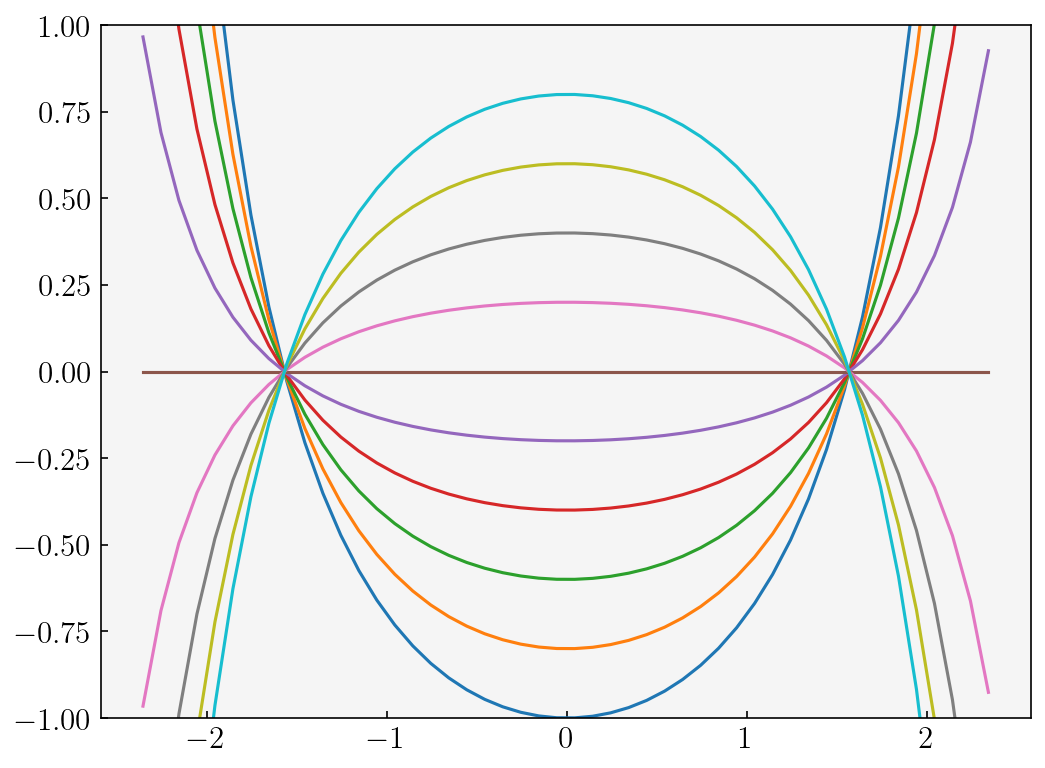

In [39]:
for i in range(len(z_arr)):
    plt.plot(theta_arr, free_fall[i])
plt.ylim(-1,1)